## Дополнительное ДЗ

## Тамогашев Кирилл

In [606]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import requests      
import time 
from bs4 import BeautifulSoup

plt.style.use('ggplot')  
%matplotlib inline

Данные взяты из магазина https://www.bookdepository.com. Исследуются бестселлеры данного магазина 

Ссылка на первую страницу https://www.bookdepository.com/search?searchTerm=best%20sellers&page=1

In [202]:
def parse_page(page):
    url = f'https://www.bookdepository.com/search?searchTerm=best%20sellers&page={page}'
    response = requests.get(url)
    tree = BeautifulSoup(response.content, 'html.parser')
    items = tree.find_all('div', {'class' : 'book-item'})
    item_list = []
    for item in items:
        if item.find('p', {'class': "price"}) is None:
            price = np.NaN
        else:
            price = item.find('p', {'class': "price"}).text.strip('US$ \n').split()[0]
        item_list.append({'Title': item.find('h3', {'class': "title"}).text.strip('$ \n'),
                     'Author': item.find('p', {'class': "author"}).text.strip('$ \n'),
                     'Price': price, 
                     'Published': item.find('p', {'class': "published"}).text.strip('$ \n'),
                     'Format': item.find('p', {'class': "format"}).text.strip('$ \n'),
                     'Number of stars': len(item.find_all('span', {'class': "star full-star"}))
                     })
    return pd.DataFrame(item_list)

In [227]:
book_depository = parse_page(1)

In [228]:
for i in range(2, 60):
    df = parse_page(i)
    book_depository = pd.concat([book_depository, df], ignore_index=True)

In [232]:
book_depository.head()

,Title,Author,Price,Published,Format,Number of stars
0,El Misterio de Salem's Lot / Salem's Lot,Stephen King,13.74,30 Jul 2005,Paperback,4
1,The Hummingbird Bakery Cookbook,Tarek Malouf,17.08,05 Oct 2017,Hardback,4
2,La via del tarot/ The Way of the Tarot,Alejandro Jodorowsky,14.67,01 Apr 2006,Paperback,4
3,Cementerio De Animales/pet Cemetary,Stephen King,12.44,30 Jun 2005,Paperback,4
4,The Forbidden Best-Sellers of Pre-Revolutionar...,Robert Darnton,25.57,17 Apr 1996,Paperback,4


Колонка 'Title' - название книги

Колонка 'Author' - автор 

Колонка 'Author' - цена в US$

Колонка 'Published' - дата юубликации книги 

Колонка 'Format' - формат книги: мягкая обложка, жесткая обложка или CD/Audio 

Колонка 'Number of stars'- ретинг, количество звезд из 5 

## Обработаем полученный датасет

Цена является важным показателем, поэтому удалять ее не будем. Все гипотеы, связанные с ценой, исследуем на выборке в 658 экземпляров. 

На данный момент необходимо сделать несколько шагов:

      1) изминить тип данных в колонке 'price' на float
      
      2) извенить тип данных в колонке 'Published' на date

In [236]:
book_depository["Price"] = book_depository["Price"].apply(pd.to_numeric)

In [238]:
book_depository["Published"] = book_depository["Published"].apply(pd.to_datetime)

In [241]:
book_depository.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1770 entries, 0 to 1769
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Title            1770 non-null   object        
 1   Author           1770 non-null   object        
 2   Price            658 non-null    float64       
 3   Published        1735 non-null   datetime64[ns]
 4   Format           1770 non-null   object        
 5   Number of stars  1770 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 83.1+ KB


Я скопировал датасет в новый по техническим причинам, чтобы в случае ошибки не запускать парсинг заново

In [440]:
df = pd.DataFrame.copy(book_depository)

In [441]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1770 entries, 0 to 1769
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Title            1770 non-null   object        
 1   Author           1770 non-null   object        
 2   Price            658 non-null    float64       
 3   Published        1735 non-null   datetime64[ns]
 4   Format           1770 non-null   object        
 5   Number of stars  1770 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 83.1+ KB


In [442]:
df.head()

,Title,Author,Price,Published,Format,Number of stars
0,El Misterio de Salem's Lot / Salem's Lot,Stephen King,13.74,2005-07-30,Paperback,4
1,The Hummingbird Bakery Cookbook,Tarek Malouf,17.08,2017-10-05,Hardback,4
2,La via del tarot/ The Way of the Tarot,Alejandro Jodorowsky,14.67,2006-04-01,Paperback,4
3,Cementerio De Animales/pet Cemetary,Stephen King,12.44,2005-06-30,Paperback,4
4,The Forbidden Best-Sellers of Pre-Revolutionar...,Robert Darnton,25.57,1996-04-17,Paperback,4


Теперь добавим новую колонку: мы определим, является ли автор мужчиной или женщиной 

In [244]:
!pip install nltk

In [246]:
from nltk.corpus import names 
import nltk 
import random 

Скачаем классификатор по именам и обучем его различать мужские и женские имена

In [247]:
def gender_features(word): 
    return {'last_letters':word[-1]}

In [282]:
male = open("male.txt", "r")
female = open("female.txt", "r")

male = male.read().split()[31:]
female = female.read().split()[31:]

In [284]:
female[:10]

['Abagail',
 'Abbe',
 'Abbey',
 'Abbi',
 'Abbie',
 'Abby',
 'Abigael',
 'Abigail',
 'Abigale',
 'Abra']

In [285]:
labeled_names = ([(name, 'male') for name in male ]+
             [(name, 'female') for name in female])
random.shuffle(labeled_names)
featuresets = [(gender_features(n), gender)  
               for (n, gender)in labeled_names]
train_set, test_set = featuresets[500:], featuresets[:500] 

In [286]:
classifier = nltk.NaiveBayesClassifier.train(train_set)

In [543]:
print(classifier.classify(gender_features('Alexander'))) 

male


In [305]:
print(nltk.classify.accuracy(classifier, train_set)) 

0.7614826752618856


In [443]:
df["Sex"] = 0
df.head()

,Title,Author,Price,Published,Format,Number of stars,Sex
0,El Misterio de Salem's Lot / Salem's Lot,Stephen King,13.74,2005-07-30,Paperback,4,0
1,The Hummingbird Bakery Cookbook,Tarek Malouf,17.08,2017-10-05,Hardback,4,0
2,La via del tarot/ The Way of the Tarot,Alejandro Jodorowsky,14.67,2006-04-01,Paperback,4,0
3,Cementerio De Animales/pet Cemetary,Stephen King,12.44,2005-06-30,Paperback,4,0
4,The Forbidden Best-Sellers of Pre-Revolutionar...,Robert Darnton,25.57,1996-04-17,Paperback,4,0


In [444]:
for i in range(1770):
    author = df["Author"].loc[i] #.strip(' L. .').split()[0]
    if len(author) == 0:
        df["Author"].loc[i] = np.NaN
    else:
        name = author.strip(' L. .').split()[0]
        if len(name) > 1:
            sex = classifier.classify(gender_features(name))
        else:
            sex = np.NaN
    df["Sex"].loc[i] = sex

In [445]:
df.head()

,Title,Author,Price,Published,Format,Number of stars,Sex
0,El Misterio de Salem's Lot / Salem's Lot,Stephen King,13.74,2005-07-30,Paperback,4,male
1,The Hummingbird Bakery Cookbook,Tarek Malouf,17.08,2017-10-05,Hardback,4,male
2,La via del tarot/ The Way of the Tarot,Alejandro Jodorowsky,14.67,2006-04-01,Paperback,4,male
3,Cementerio De Animales/pet Cemetary,Stephen King,12.44,2005-06-30,Paperback,4,male
4,The Forbidden Best-Sellers of Pre-Revolutionar...,Robert Darnton,25.57,1996-04-17,Paperback,4,male


In [446]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1770 entries, 0 to 1769
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Title            1770 non-null   object        
 1   Author           1732 non-null   object        
 2   Price            658 non-null    float64       
 3   Published        1735 non-null   datetime64[ns]
 4   Format           1770 non-null   object        
 5   Number of stars  1770 non-null   int64         
 6   Sex              1624 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 96.9+ KB


Мы почистили колонку Author и добавили колонку Sex. В ообоих колонках появились пропущенные значения, однако эти пропуски нзначительны.

In [447]:
df.head(10)

,Title,Author,Price,Published,Format,Number of stars,Sex
0,El Misterio de Salem's Lot / Salem's Lot,Stephen King,13.74,2005-07-30,Paperback,4,male
1,The Hummingbird Bakery Cookbook,Tarek Malouf,17.08,2017-10-05,Hardback,4,male
2,La via del tarot/ The Way of the Tarot,Alejandro Jodorowsky,14.67,2006-04-01,Paperback,4,male
3,Cementerio De Animales/pet Cemetary,Stephen King,12.44,2005-06-30,Paperback,4,male
4,The Forbidden Best-Sellers of Pre-Revolutionar...,Robert Darnton,25.57,1996-04-17,Paperback,4,male
5,Adult Coloring Books Best Sellers Sampler,Richard Edward Hargreaves,12.15,2015-06-15,Paperback,0,male
6,Young Adult Fiction Best Sellers,Jackson Dean Chase,8.38,2015-11-02,Paperback,4,male
7,Fighting for Your Marriage,Howard J. Markman,22.38,2010-05-18,Paperback,4,male
8,Marina,Carlos Ruiz Zafon,11.00,2009-02-01,Paperback,4,male
9,Cujo,Stephen King,11.41,2005-09-01,Paperback,3,male


## Посмотрим на стоимость книг в зависимости от пола автора 

In [539]:
mean_m = df.Price[(df.Sex == 'male')].mean()
median_m = df.Price[(df.Sex == 'male')].median()
mode_m = df.Price[(df.Sex == 'male')].mode()[0]
mean_f = df.Price[(df.Sex == 'female')].mean()
median_f = df.Price[(df.Sex == 'female')].median()
mode_f = df.Price[(df.Sex == 'female')].mode()[0]

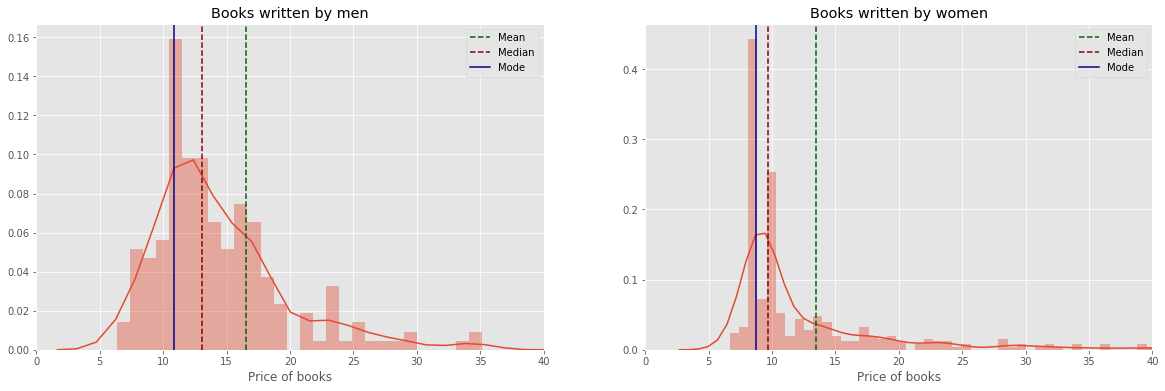

In [590]:
f, (ax_men, ax_women) = plt.subplots(1, 2, figsize=(20,6), sharey=False)

sns.distplot(df.Price[(df.Sex == 'male')], bins=180, ax=ax_men, norm_hist=True)
ax_men.axvline(mean_m, color='darkgreen', linestyle='--')
ax_men.axvline(median_m, color='darkred', linestyle='--')
ax_men.axvline(mode_m, color='darkblue', linestyle='-')
ax_men.set_xlabel('Price of books')
ax_men.set_title('Books written by men')
ax_men.set_xlim(0, 40)
ax_men.legend({'Mean':mean_m,'Median':median_m,'Mode':mode_m})


sns.distplot(df.Price[(df.Sex == 'female')], bins=120, ax=ax_women, norm_hist=True)
ax_women.axvline(mean_f, color='darkgreen', linestyle='--')
ax_women.axvline(median_f, color='darkred', linestyle='--')
ax_women.axvline(mode_f, color='darkblue', linestyle='-')
ax_women.set_xlabel('Price of books')
ax_women.set_title('Books written by women')
ax_women.set_xlim(0, 40)
ax_women.legend({'Mean':mean_f,'Median':median_f,'Mode':mode_f})

plt.show()

In [634]:
print(f'mean among male authors:      {mean_m}')       
print(f'median among male authors:    {median_m}')            
print(f'mode among male authors:      {mode_m}')  
print('-------------------------') 
print(f'mean among female authors:    {mean_f}')
print(f'median among female authors:  {median_f}')
print(f'mode among female authors:    {mode_f}')

mean among male authors:      16.523413461538453
median among male authors:    13.08
mode among male authors:      10.85
-------------------------
mean among female authors:    13.489764705882338
median among female authors:  9.71
mode among female authors:    8.74


## Посмотрим на стоимость книг в зависимости от рейтинга (количества звезд)

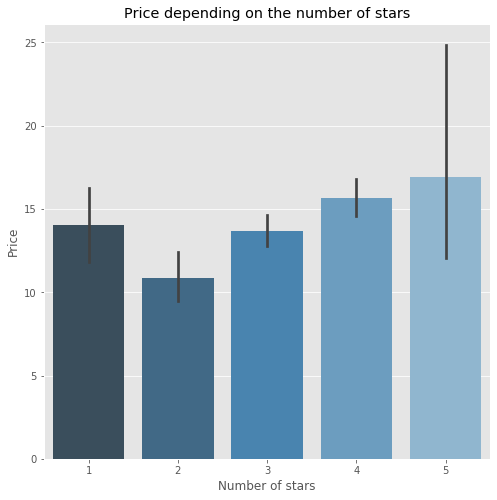

In [568]:
plt.figure(figsize=(8, 8))
sns.barplot(x='Number of stars', y='Price',  data=df[(df['Number of stars'] != 0)], palette="Blues_d")
plt.title('Price depending on the number of stars')
plt.show()

## Стоимость книг в зависимости от пола и года публикации 

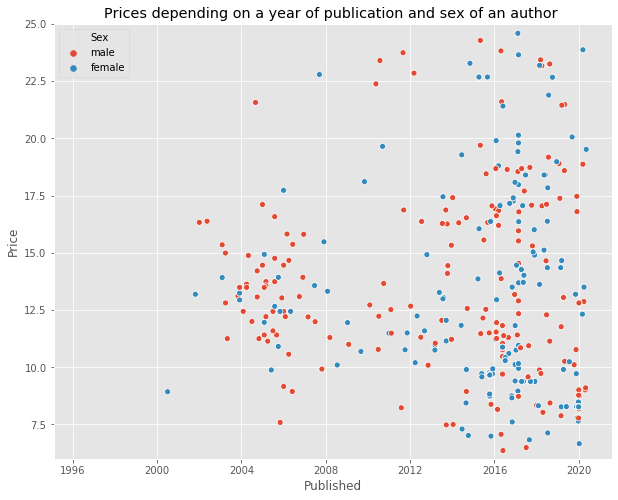

In [645]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Published', y="Price" , hue="Sex",  data=df)
plt.title("Prices depending on a year of publication and sex of an author ")
plt.ylim(6, 25)
plt.show()

## Стоимость книг в зависимости от формата 

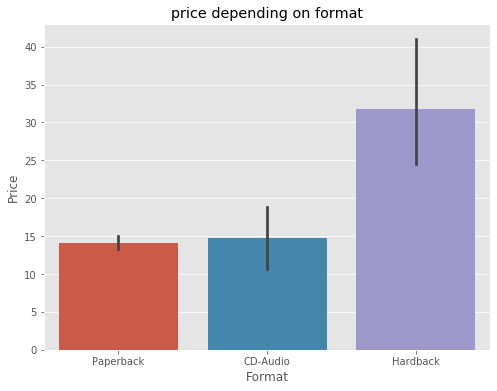

In [674]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Format', y='Price', data=df[(df.Format != 'Book')], order=['Paperback', 'CD-Audio',   'Hardback'])
plt.title('price depending on format')
plt.show()

## Проверка гипотез

 Проверим гипотезу о средней стоимости книг, написанных мужчинами и женщинами:

 $H_0: \mu_{f}=\mu_{m} $ в среднем стоимость книги, написанной женщиной, равна стоимости книги, написанной мужчиной 

 $H_1: \mu_{f} < \mu_{m}$ книги, написанные мужчиной, в среднем стоят дороже 

Оценим $\mu_{m}$ и $\mu_{f}$ с помощью доверительных интервалов для мат. ождания при неизвестном распределении. Возьмем уровень значимости 99%:

$z_{\frac{\alpha}{2}} = 2,56$

In [663]:
men = df.Price[(df.Sex =='male')].dropna()
men_mean = men.mean()
men_std = men.std()
men_len = len(men)

women = df.Price[(df.Sex =='female')].dropna()
women_mean = women.mean()
women_std = women.std()
women_len = len(women)

In [666]:
print(f'Доверительный интервал для mu_m:   {men_mean - 2.56 * men_std / men_len} < mu_m <  {men_mean + 2.56 * men_std / men_len}')
print(f'Доверительный интервал для mu_f:   {women_mean - 2.56 * women_std / women_len} < mu_f <  {women_mean + 2.56 * women_std / women_len}')

Доверительный интервал для mu_m:   16.302269676884585 < mu_m <  16.744557246192322
Доверительный интервал для mu_f:   13.419502081709684 < mu_f <  13.560027330054993


Доверительные интервалы не пересекаюся, из проведенного анализа можно сделать вывод, что $\mu_{f} < \mu_{m}$, следовательно, $H_{0}$ отвергается в пользу $H_{1}$